In [36]:
import tensorflow as tf
import numpy as np
import datetime

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [38]:
data

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timeUTC
0,1576144800,7219.93,7149.15,7170.18,1536.79,11041994.81,7166.14,direct,NaN,2019-12-12 19:00:00
1,1576148400,7208.36,7166.03,7166.14,785.11,5654607.43,7199.79,direct,NaN,2019-12-12 20:00:00
2,1576152000,7222.43,7194.87,7199.79,672.46,4855213.22,7199.97,direct,NaN,2019-12-12 21:00:00
3,1576155600,7211.80,7187.29,7199.97,807.61,5821087.81,7201.38,direct,NaN,2019-12-12 22:00:00
4,1576159200,7229.22,7152.84,7201.38,1606.06,11537799.57,7173.50,direct,NaN,2019-12-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...
10000,1612144800,33847.46,33257.39,33450.01,2066.49,69445570.35,33675.45,direct,NaN,2021-02-01 11:00:00
10001,1612148400,33779.76,33505.50,33675.45,1173.82,39473368.04,33590.20,direct,NaN,2021-02-01 12:00:00
10002,1612152000,33945.41,33404.87,33590.20,1430.06,48159838.72,33576.82,direct,NaN,2021-02-01 13:00:00
10003,1612155600,33907.89,33467.87,33576.82,1198.20,40319458.23,33803.02,direct,NaN,2021-02-01 14:00:00


In [39]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [40]:
np.max(values)

7859574300.0

In [41]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

8004 1000 1001


In [42]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [43]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

7812
808
809


In [44]:
print(trainX.shape)
print(trainY.shape)

(7812, 168, 6)
(7812, 24)


In [45]:
'''
trainY=np.reshape(trainY,(trainY.shape[0],trainY.shape[1],1))
valY=np.reshape(valY,(valY.shape[0],valY.shape[1],1))
testY=np.reshape(testY,(testY.shape[0],testY.shape[1],1))
'''

'\ntrainY=np.reshape(trainY,(trainY.shape[0],trainY.shape[1],1))\nvalY=np.reshape(valY,(valY.shape[0],valY.shape[1],1))\ntestY=np.reshape(testY,(testY.shape[0],testY.shape[1],1))\n'

In [46]:
'''
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))
'''

'\ntrainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))\nvalX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))\ntestX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))\n'

In [47]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

## cnn-lstm

In [48]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [49]:
model.load_weights("saved_weights/btc_cnnlstm_multistep.hdf5")

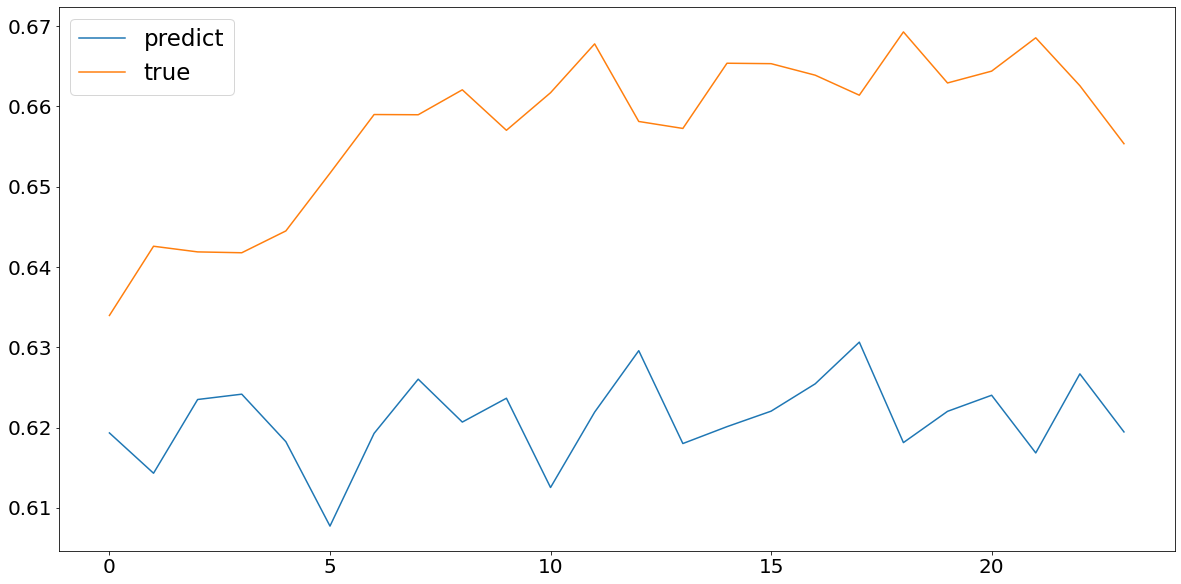

Test RMSE: 0.03773
Test MAE: 0.03638
Test MSE: 0.00142
Test RMSE: 296555374.90103
Test MAE: 285916640.00000


In [50]:
from matplotlib import pyplot
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*2]
testy=testY[24*2]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [51]:
7812 + 808 + 809 

9429

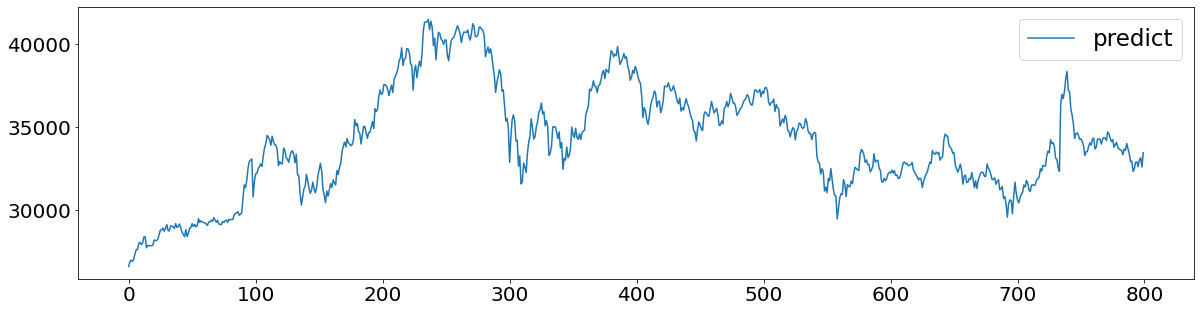

In [52]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = values[9200:10000,0]
plt.figure(figsize=(20,5))
pyplot.plot(yhat, label='predict')
pyplot.legend()
pyplot.show()

# true data 그래프 비교

### 논문 true 그래프

In [53]:
btc_2 = pd.read_csv('btc_2_11.csv')

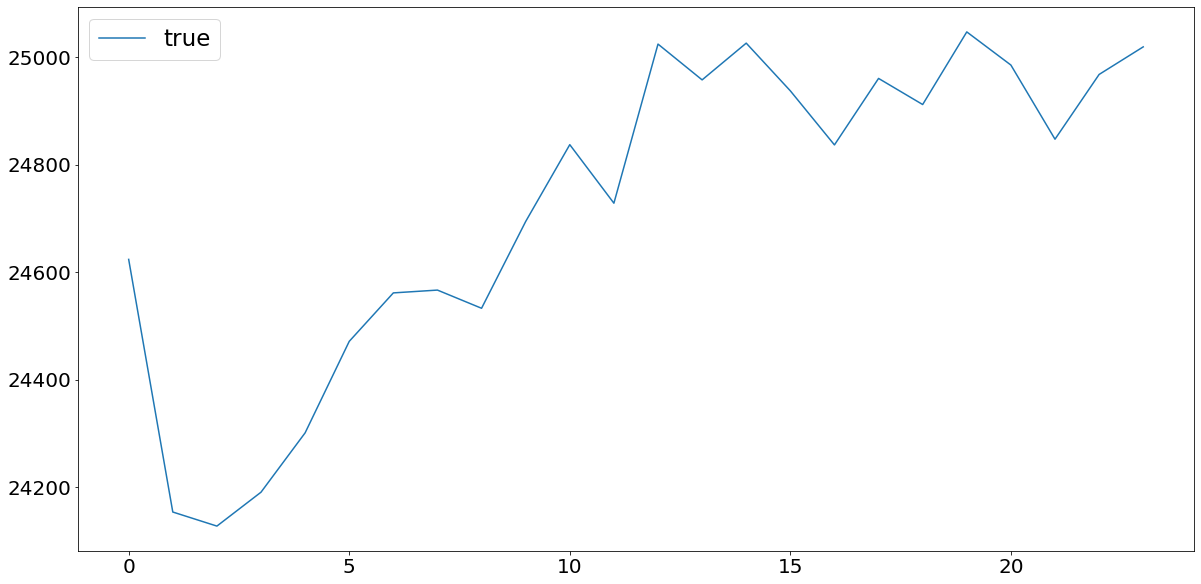

In [54]:
from sklearn.metrics import *

from matplotlib import pyplot
kk = btc_2
plt.figure(figsize=(20,10))
pyplot.plot(kk, label='true')
pyplot.legend()

### 현재 true 그래프

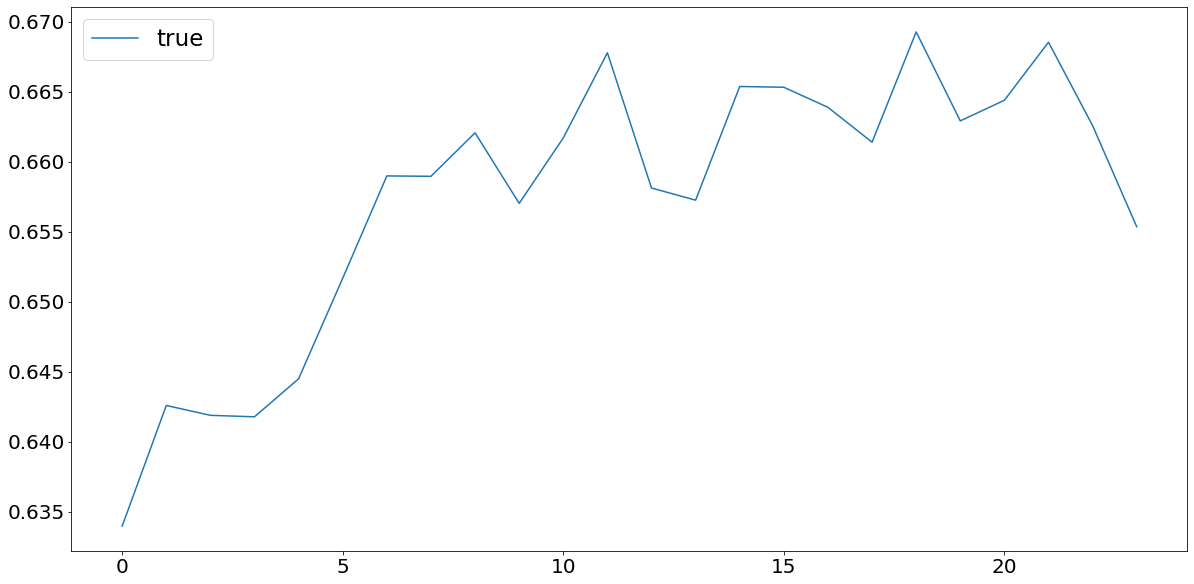

In [55]:
from matplotlib import pyplot
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
testy=testY[24*2]
testy=testy.reshape(-1,1)
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()